In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import torchvision.transforms as transforms
import pickle
import gzip

In [ ]:
# Load the dataset
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/DPLEARNING/U_Net_Segmentation
filename='nuclei_cells_segmentations.pck.gz'
fp = gzip.open(filename,'rb')

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/DPLEARNING


**Image segmentation** is an important task in  computer vision. The goal is to find multiple areas in an image and to assign labels to these area.  It provides a different kind of information than:
- **image classification** caracterizes images with global labels;
- **object detection** usually relies on finding bounding-boxes around  detected objects

Segmentation is useful and can be used in real-world applications such as medical imaging, clothes segmentation, flooding maps, self-driving cars, etc. There are two types of image segmentation:
- Semantic segmentation: classify each pixel with a label.
- Instance segmentation: classify each pixel and differentiate each object instance.

U-Net is a semantic segmentation technique [originally proposed for medical imaging segmentation](https://arxiv.org/abs/1505.04597). It’s one of the earlier deep learning segmentation models. This architecture is still widely used in more advanced models like Generative Adversarial or Diffusion Network.

The model architecture is fairly simple: an encoder (for downsampling) and a decoder (for upsampling) with skip connections. U-Net is only based on convolutions. More specifically, the output classification is done at pixel level with a *(1,1)* convolution. It has therefore  the following advantages:
- parameter and data efficiency,
- independent of the input size.

The following image is taken from the original paper:

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png"  width="60%" height="30%">


The goal of this lab session is to develop the U-Net architecture for image semantic segmentation. To start we will consider a binary segmentation task.  

#  Cell nuclei segmentation: the dataset

Cell nuclei segmentation is an essential step in the biological analysis of microscopy images.
This segmentation can be manually achieved with dedicated software, however it is very costly.
In this lab session, the starting point is this [nature paper](https://www.nature.com/articles/s41597-020-00608-w). To quote some part of the paper:

Fully-automated nuclear image segmentation is the prerequisite to ensure statistically significant, quantitative analyses of tissue preparations,applied in digital pathology or quantitative microscopy. The design of segmentation methods that work independently of the tissue type or preparation is complex, due to variations in nuclear morphology, staining intensity, cell density and nuclei aggregations. Machine learning-based segmentation methods can overcome these challenges, however high quality expert-annotated images are required for training. Currently, the limited number of annotated fluorescence image datasets publicly available do not cover a broad range of tissues and preparations. We present a comprehensive, annotated dataset including tightly aggregated nuclei of multiple tissues for the training of machine learning-based nuclear segmentation algorithms. The proposed dataset covers sample preparation methods frequently used in quantitative immunofluorescence microscopy.

To spare some preprocessing time, this lab session starts with this pickle

In [ ]:
X, Y = pickle.load(fp)
print(X.shape, Y.shape)
N = X.shape[0]

torch.Size([79, 1, 128, 128]) torch.Size([79, 1, 128, 128])


Here we can see in the left the original image and in the rigth the segmented one.

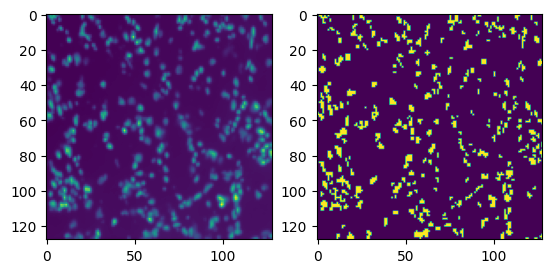

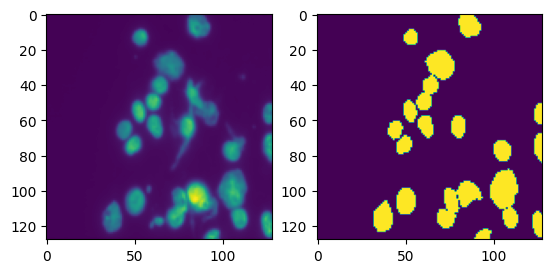

In [ ]:
for i in (3,14):
    figs, axs = plt.subplots(1,2)
    axs[0].imshow(X[i].squeeze())
    axs[1].imshow(Y[i].squeeze())

This pickle contains a modified version of the dataset:
- the same amount of images
- all the images are resized to 128,128
- the segmentation task is converted in a binary pixel classification: nuclei or not.

The goal is now to train a U-Net on this dataset (70 images for training and 9 for "test").

# U-Net

Following the previous picture of U-Net, the network is composed of 3 parts: encoder, bottleneck, decoder.  
These three steps rely on a convolutional block (convolution, relu, convolution, relu)

The first step is the **encoder**. The goal is to compress the  "geometrical" information with local features. The encoder first applies a convolution of kernel size (3,3) to extract $F=64$ features. Then the information is compressed using max-pooling (factor 2). The next step does the same:  extract $2\times F=128$ features from the $F=64$, then compression with max-pooling. This operation is repeated 4 times in total to get at the end $F\times 8 = 512$ channels that represent global features extracted from the input image.

The **bottleneck** layer is a convolutional layer which doubles the number of channels. The idea is to create a "dense" representation of the image to gather both global and local features.

The **decoder** part is similar to the encoder part but reversed. While we used max-pooling for downsampling in the encoder, the upsampling operation consists in **transposed convolution**. The goal is to increase (so upsample) the spatial dimensions of intermediate feature maps.

The last peculiarity is the output layer for classification at the pixel level. In U-Net this last layer is (once again) a convolutional layer. This means that with the last hidden layer, we recover the same spatial dimension as the input with $F$ feature maps. The classification is carried out for each pixel independently, but the decision is based on $F$ features that encode global information.


## ConvTranspose2D

In pytorch, transposed convolution is achieved with the module ConvTranspose2D (for images or 2D objects).
To better understand how it works, it can be useful to play with it.


In [ ]:
c = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=2, stride=1, bias=True)
print(c.weight, c.bias)

Parameter containing:
tensor([[[[-0.1417,  0.1684],
          [-0.2037,  0.2958]]]], requires_grad=True) Parameter containing:
tensor([-0.1361], requires_grad=True)


As you can see, the operation is parametrized by a convolution mask $\mathbf{W}$ and one bias term. For one value $v$ in the input, we get as output $v\times\mathbf{W}+b$. As an illustration, we can consider a simple image with one channel. To start, it is easier to start without the bias term:


In [ ]:
im = th.zeros(1,1,2,2)
c = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=2, stride=1, bias=False)
print("The weights: ",c.weight)
for i in range(4):
    im = th.zeros(1,1,2,2)
    im[0,0,i%2,i//2] = 1
    print("image: ",im)
    print("output: ",c(im))

The weights:  Parameter containing:
tensor([[[[-0.4221,  0.1008],
          [ 0.3433, -0.1252]]]], requires_grad=True)
image:  tensor([[[[1., 0.],
          [0., 0.]]]])
output:  tensor([[[[-0.4221,  0.1008,  0.0000],
          [ 0.3433, -0.1252,  0.0000],
          [ 0.0000,  0.0000,  0.0000]]]], grad_fn=<ConvolutionBackward0>)
image:  tensor([[[[0., 0.],
          [1., 0.]]]])
output:  tensor([[[[ 0.0000,  0.0000,  0.0000],
          [-0.4221,  0.1008,  0.0000],
          [ 0.3433, -0.1252,  0.0000]]]], grad_fn=<ConvolutionBackward0>)
image:  tensor([[[[0., 1.],
          [0., 0.]]]])
output:  tensor([[[[ 0.0000, -0.4221,  0.1008],
          [ 0.0000,  0.3433, -0.1252],
          [ 0.0000,  0.0000,  0.0000]]]], grad_fn=<ConvolutionBackward0>)
image:  tensor([[[[0., 0.],
          [0., 1.]]]])
output:  tensor([[[[ 0.0000,  0.0000,  0.0000],
          [ 0.0000, -0.4221,  0.1008],
          [ 0.0000,  0.3433, -0.1252]]]], grad_fn=<ConvolutionBackward0>)


Try now with an image full of 1 and explain the result:

In [ ]:
im = th.ones(1,1,2,2)
print(c(im))


tensor([[[[-0.4221, -0.3212,  0.1008],
          [-0.0788, -0.1031, -0.0243],
          [ 0.3433,  0.2181, -0.1252]]]], grad_fn=<ConvolutionBackward0>)


Now we can consider different stride:

In [ ]:
c = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=2, stride=2,  bias=False)
print(c.weight)
for i in range(4):
    print("...")
    im = th.zeros(1,1,2,2)
    im[0,0,i%2,i//2] = 1
    print(im)
    print(c(im))

Parameter containing:
tensor([[[[-0.1933, -0.3240],
          [-0.1754, -0.3860]]]], requires_grad=True)
...
tensor([[[[1., 0.],
          [0., 0.]]]])
tensor([[[[-0.1933, -0.3240,  0.0000,  0.0000],
          [-0.1754, -0.3860,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000]]]],
       grad_fn=<ConvolutionBackward0>)
...
tensor([[[[0., 0.],
          [1., 0.]]]])
tensor([[[[ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [-0.1933, -0.3240,  0.0000,  0.0000],
          [-0.1754, -0.3860,  0.0000,  0.0000]]]],
       grad_fn=<ConvolutionBackward0>)
...
tensor([[[[0., 1.],
          [0., 0.]]]])
tensor([[[[ 0.0000,  0.0000, -0.1933, -0.3240],
          [ 0.0000,  0.0000, -0.1754, -0.3860],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000]]]],
       grad_fn=<ConvolutionBackward0>)
...
tensor([[[[0., 0.],
          [0., 1.]]]])
tenso

Try to understand the previous and the next examples and how it can be used to upsample.

In [ ]:
im = th.ones(1,1,2,2)
c(im)

tensor([[[[-0.1933, -0.3240, -0.1933, -0.3240],
          [-0.1754, -0.3860, -0.1754, -0.3860],
          [-0.1933, -0.3240, -0.1933, -0.3240],
          [-0.1754, -0.3860, -0.1754, -0.3860]]]],
       grad_fn=<ConvolutionBackward0>)

## U-Net: step by step

Now the goal is to implement U-Net. As a proposed roadmap we propose the following step:
- a function to create a convolutional block
- a module for the encoder
- a module for the decoder
- and a U-Net module to wrap everything

The number of feature map ($F=64$ in the original work) must be a variable of the UNet. For the first round of experiment, we can use $F=8$.  


**TODO:**
- run the training on the 70 first images and spare the last 9 for evaluation
- after the training process, look at the results on some training images and the evaluation ones.


In [ ]:
# TODO : paste here the training function you wrote before.
# Of course you can improve it if you want during the lab session.
# Especially in terms of parameters.
import time

def train(model, epochs=30,verbose=False,lr=0.001, batch_size=10, plot = False):
    inicio = time.time()

    optimizer=th.optim.Adam(model.parameters(),lr=lr)
    ### Mini-batching and shuffle
    Ntrain = Xtrain.shape[0]
    Nvalid = Xvalid.shape[0]
    idx = np.arange(Ntrain)
    nbatch = int(Ntrain/batch_size)
    ### store results
    train_losses,valid_losses, valid_accuracies=[],[],[]

    ########################
    # Training #############
    ########################
    for e in range(epochs):
        np.random.shuffle(idx)
        running_loss=0
        totaln = 0
        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            images = Xtrain[ids] # Initial images
            labels = Ytrain[ids] # Segmentation
            totaln += labels.shape[0] # the number of samples
            optimizer.zero_grad() #Reinitializing the grad
            segm_out  = model(images)

            # As loss function we'll use the cross entropy loss which is a combination of Logsoftmax and NLLLoss
            # It is useful when training a classification problem with C classes (in this case we have 2 classes)

            # Nevertheless, we must reshape the tensors to make them have the correct size

            # First of all, we do a permutation so that number of desired segments would be on 4th dimension
            segm_out = segm_out.permute(0, 2, 3, 1)

            # And we reshape them to have a comparison vectors
            [m,ch, width_out, height_out] = labels.shape
            segm_out = segm_out.reshape(m*width_out*height_out, 2)
            labels = labels.reshape(m*width_out*height_out).to(th.long) #target must be in dtype long

            loss = loss_fn(segm_out,labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
        # training is over for one epoch
        # now compute interesting quantities
        accuracy=0
        valid_loss = 0
        with th.no_grad():
            model.eval()
            images = Xvalid
            labels = Yvalid
            segm_out = model(images)

            # First of all, we do a permutation so that number of desired segments would be on 4th dimension
            segm_out = segm_out.permute(0, 2, 3, 1)

            # And we reshape them to have a comparison vectors
            [m,ch, width_out, height_out] = labels.shape

            segm_out = segm_out.reshape(m*width_out*height_out, 2)
            labels = labels.reshape(m*width_out*height_out).to(th.long) #target must be in dtype long

            valid_loss = loss_fn(segm_out,labels)
            valid_losses.append(100*valid_loss/Nvalid)
        model.train()
        train_losses.append(100*running_loss/Ntrain)

        if verbose:
            print("Epoch: {}\t".format(e+1),
                      "train Loss: {:.5f}.. ".format(train_losses[-1]),
                      "valid Loss: {:.5f}.. ".format(valid_losses[-1]))

    final = time.time()

    print("Run Time: {}\t".format(final-inicio))

    #########
    # plot ##
    #########
    if plot :
      fig, ax = plt.subplots(1,2,figsize = (9, 3),tight_layout = True)
      ax[0].plot(train_losses,'k')
      ax[0].set_ylabel(r" Train losses ", size=15)
      ax[0].set_xlabel(r" Epoch ", size=15)
      ax[0].grid('minor')
      ax[0].set_ylim(bottom=0)

      ax[1].plot(valid_losses,'k')
      ax[1].set_ylim(bottom=0)
      ax[1].set_ylabel(r" Valid losses ", size=15)
      ax[1].set_xlabel(r" Epoch ", size=15)
      ax[1].grid('minor')
      ax[1].set_ylim(bottom=0)

      plt.show()

In [ ]:
Xtrain, Ytrain = X[:70] , Y[:70]
Xvalid, Yvalid = X[70:79] , Y[70:79]

print(Xtrain.shape, Ytrain.shape)
print(Xvalid.shape, Yvalid.shape)

torch.Size([70, 1, 128, 128]) torch.Size([70, 1, 128, 128])
torch.Size([9, 1, 128, 128]) torch.Size([9, 1, 128, 128])


In [ ]:
def convolutional_block(in_channel, out_channel, kernel = 3) :

  return nn.Sequential(nn.Conv2d(in_channels = in_channel, out_channels = out_channel, kernel_size = kernel, padding = 1),
                       nn.ReLU(),
                       nn.Conv2d(in_channels = out_channel, out_channels = out_channel, kernel_size = kernel, padding = 1),
                       nn.ReLU())



class encoder(nn.Module):
    # TODO :
    def __init__(self, in_ch, out_ch):
        super(encoder, self).__init__()

        self.conv_block = convolutional_block(in_channel = in_ch, out_channel = out_ch)
        self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)

    def forward(self,x) :

      out1 = self.conv_block(x)
      out2 = self.maxpool(out1)

      return out1, out2


class decoder(nn.Module):
    # TODO :
    def __init__(self, in_ch, out_ch):
        super(decoder, self).__init__()

        self.conv_block = convolutional_block(in_channel = 2*out_ch, out_channel = out_ch)
        self.convtrans = nn.ConvTranspose2d(in_channels = in_ch, out_channels = out_ch, kernel_size=2, stride=2)

    def forward(self, x, skip) :

        output = self.convtrans(x)
        conc = th.cat((output,skip), dim = 1)

        return self.conv_block(conc)


class U_Net(nn.Module):
    # TODO :
    def __init__(self, F):
        super(U_Net, self).__init__()

        self.Encoder1 = encoder(in_ch = 1, out_ch = 2**0*F)
        self.Encoder2 = encoder(in_ch = 2**0*F, out_ch = 2**1*F)
        self.Encoder3 = encoder(in_ch = 2**1*F, out_ch = 2**2*F)
        self.Encoder4 = encoder(in_ch = 2**2*F, out_ch = 2**3*F)

        self.b = convolutional_block(in_channel = 2**3*F, out_channel = 2**4*F)

        self.Decoder1 = decoder(in_ch = 2**4*F, out_ch = 2**3*F)
        self.Decoder2 = decoder(in_ch = 2**3*F, out_ch = 2**2*F)
        self.Decoder3 = decoder(in_ch = 2**2*F, out_ch = 2**1*F)
        self.Decoder4 = decoder(in_ch = 2*F, out_ch = F)

        self.conv1x1 = nn.Sequential(nn.Conv2d(in_channels = F, out_channels = 2,
                                               kernel_size = 1, padding = 0))

    def forward(self, x) :

        # ENCODING PART
        s1, e1 = self.Encoder1(x)
        s2, e2 = self.Encoder2(e1)
        s3, e3 = self.Encoder3(e2)
        s4, e4 = self.Encoder4(e3)

        # Bottleneck
        b = self.b(e4)

        # DECODING PART
        d1 = self.Decoder1(b, s4)
        d2 = self.Decoder2(d1, s3)
        d3 = self.Decoder3(d2, s2)
        d4 = self.Decoder4(d3, s1)
        output = self.conv1x1(d4)

        return output




U-Net output without training: 


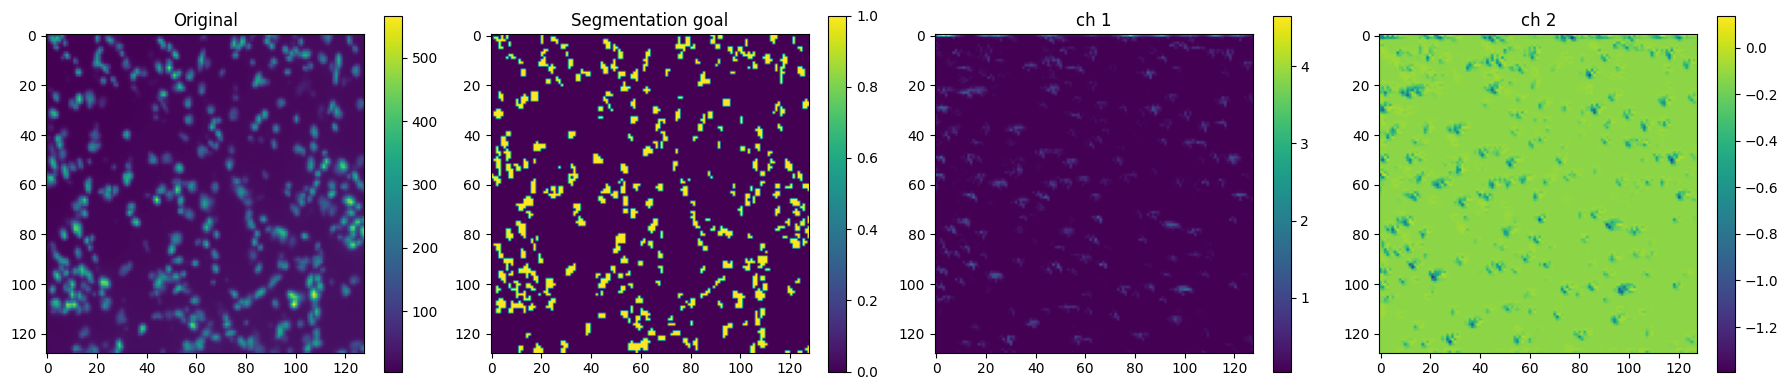

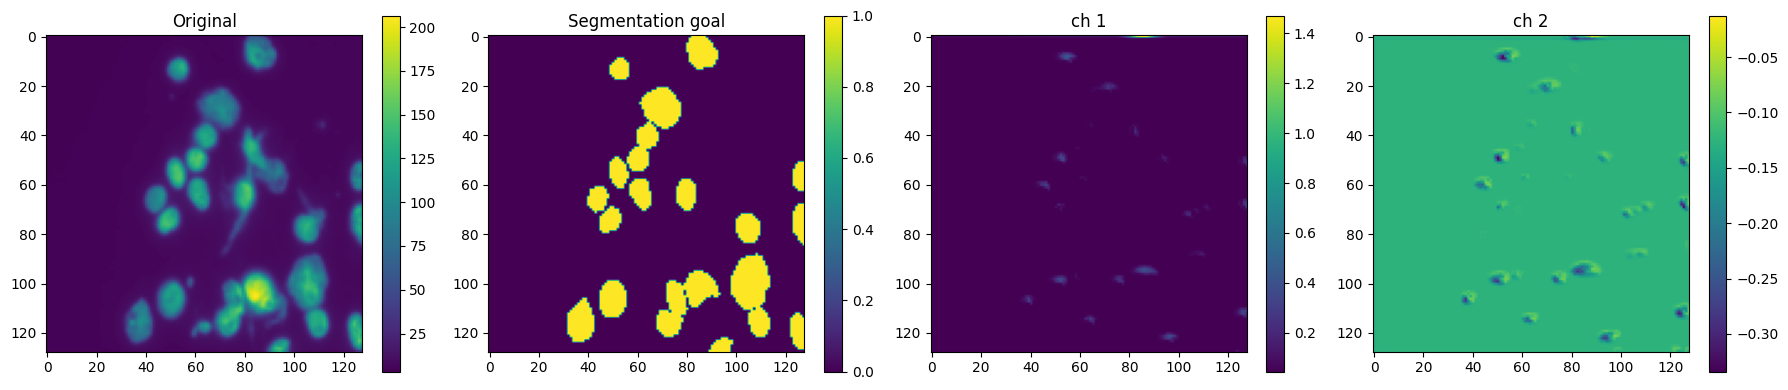

In [ ]:
F = 4
model = U_Net(F)

# First try of the model with out training
images = X
segmentation_goal = Y
segmentation_output = model(images)
print('U-Net output without training: ')

for i in (3,14):
    figs, axs = plt.subplots(1,4,figsize = (18, 4),tight_layout = True)
    im1 = axs[0].imshow(images[i].squeeze())
    axs[0].set_title('Original')
    figs.colorbar(im1, ax=axs[0],location='right')

    im2 = axs[1].imshow(segmentation_goal[i].squeeze().detach().numpy())
    axs[1].set_title('Segmentation goal')
    figs.colorbar(im2, ax=axs[1],location='right')

    im3 =axs[2].imshow(segmentation_output[i,0,:,:].squeeze().detach().numpy())
    axs[2].set_title('ch 1')
    figs.colorbar(im3, ax=axs[2],location='right')

    im3 =axs[3].imshow(segmentation_output[i,1,:,:].squeeze().detach().numpy())
    axs[3].set_title('ch 2')
    figs.colorbar(im3, ax=axs[3],location='right')




In [ ]:
#Defining and testing the lost function
#loss_fn = nn.MSELoss()
segmentation_goal = Y
segmentation_output = model(images)

loss_fn = nn.CrossEntropyLoss()

print(segmentation_output.shape,segmentation_goal.shape)

# First of all, we do a permutation so that number of desired segments would be on 4th dimension
segmentation_output = segmentation_output.permute(0, 2, 3, 1)

print(segmentation_output.shape,segmentation_goal.shape)
# And we reshape them to have a comparison vectors
[m,ch, width_out, height_out] = segmentation_goal.shape
segmentation_output = segmentation_output.reshape(m*width_out*height_out,2)
segmentation_goal = segmentation_goal.reshape(m*width_out*height_out).to(th.long)

print(segmentation_output[:5],segmentation_goal[:5])

print(segmentation_output.shape,segmentation_goal.shape)
loss =  loss_fn(segmentation_output,segmentation_goal)
print(loss)


torch.Size([79, 2, 128, 128]) torch.Size([79, 1, 128, 128])
torch.Size([79, 128, 128, 2]) torch.Size([79, 1, 128, 128])
tensor([[ 0.3041, -0.3797],
        [ 1.3676, -0.2088],
        [ 1.4413, -0.2536],
        [ 1.4865, -0.0996],
        [ 1.7316, -0.0280]], grad_fn=<SliceBackward0>) tensor([0, 0, 0, 0, 0])
torch.Size([1294336, 2]) torch.Size([1294336])
tensor(0.6537, grad_fn=<NllLossBackward0>)


Epoch: 1	 train Loss: 6.51705..  valid Loss: 7.09342.. 
Epoch: 2	 train Loss: 6.39365..  valid Loss: 6.68265.. 
Epoch: 3	 train Loss: 5.99524..  valid Loss: 5.88590.. 
Epoch: 4	 train Loss: 5.17342..  valid Loss: 5.11281.. 
Epoch: 5	 train Loss: 4.76612..  valid Loss: 4.49687.. 
Epoch: 6	 train Loss: 4.69979..  valid Loss: 4.20897.. 
Epoch: 7	 train Loss: 4.52597..  valid Loss: 4.88442.. 
Epoch: 8	 train Loss: 5.39656..  valid Loss: 4.53096.. 
Epoch: 9	 train Loss: 4.68842..  valid Loss: 3.93838.. 
Epoch: 10	 train Loss: 4.16017..  valid Loss: 4.64235.. 
Epoch: 11	 train Loss: 4.07019..  valid Loss: 3.87725.. 
Epoch: 12	 train Loss: 3.79844..  valid Loss: 3.68247.. 
Epoch: 13	 train Loss: 3.55671..  valid Loss: 3.75641.. 
Epoch: 14	 train Loss: 3.29377..  valid Loss: 3.53394.. 
Epoch: 15	 train Loss: 3.16862..  valid Loss: 3.83714.. 
Epoch: 16	 train Loss: 3.17186..  valid Loss: 3.51824.. 
Epoch: 17	 train Loss: 3.73705..  valid Loss: 3.59891.. 
Epoch: 18	 train Loss: 4.18455..  valid 

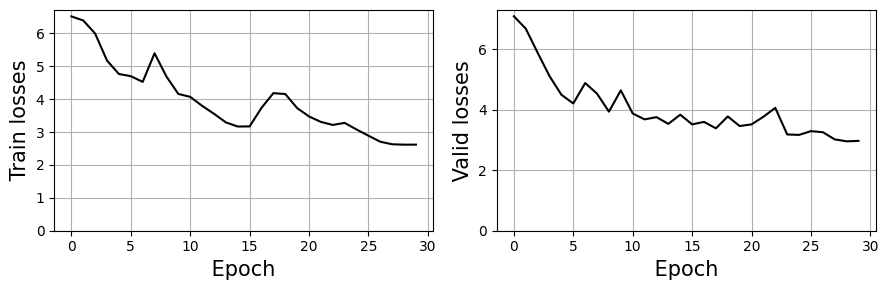

In [ ]:
# Train you model !

train(model,epochs=30, verbose = True, plot = True)

U-Net output with training: 


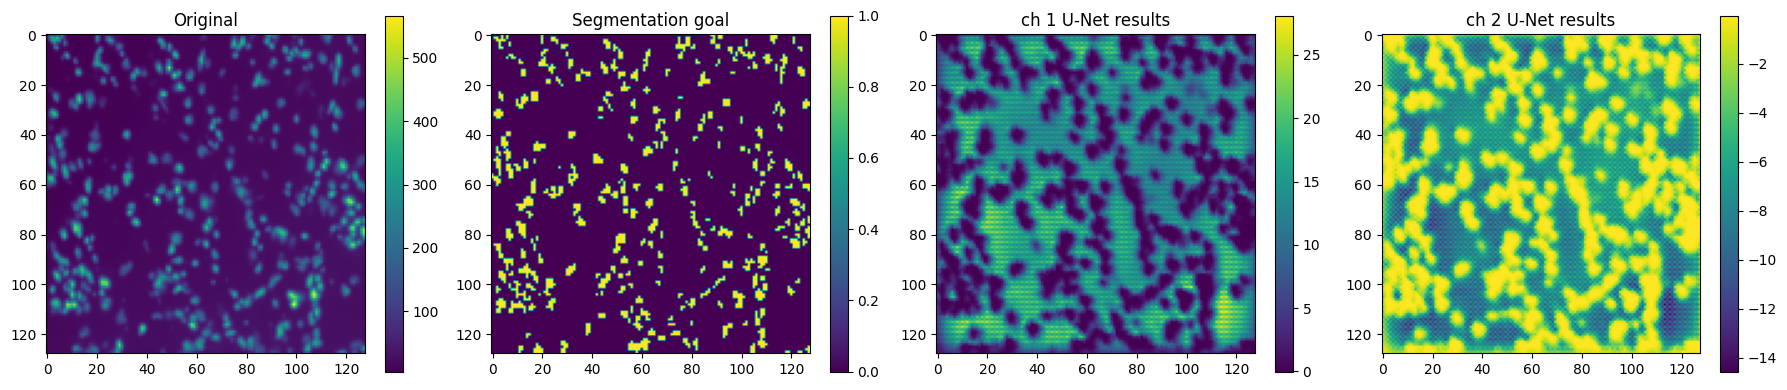

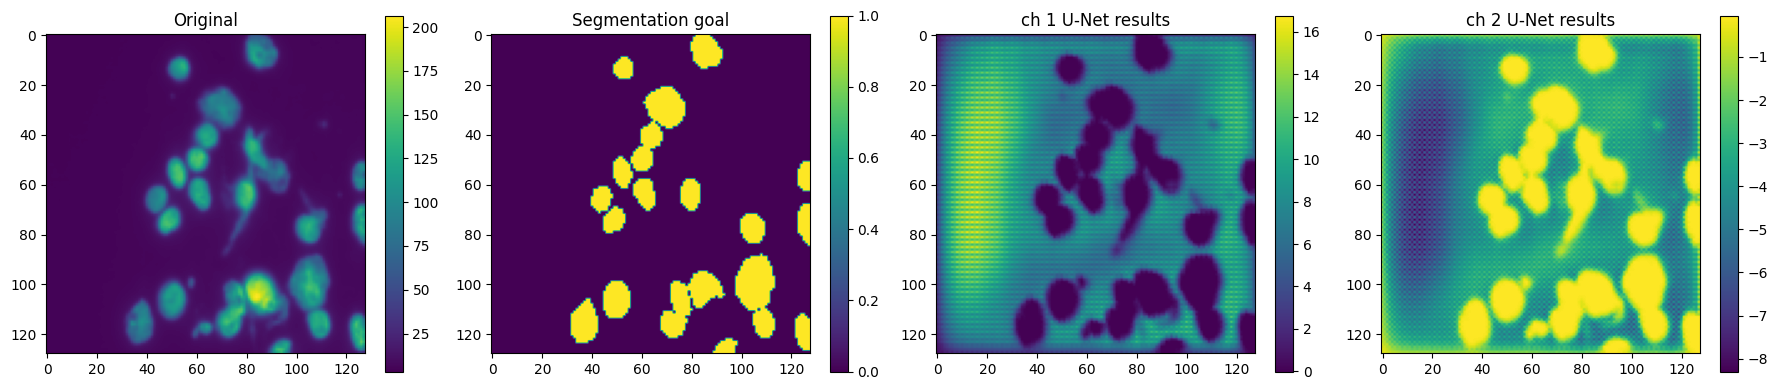

In [ ]:
#Results after training

segmentation_goal = Y
segmentation_output = model(images)
print('U-Net output with training: ')

for i in (3,14):
    figs, axs = plt.subplots(1,4,figsize = (18, 4),tight_layout = True)
    im1 = axs[0].imshow(images[i].squeeze())
    axs[0].set_title('Original')
    figs.colorbar(im1, ax=axs[0],location='right')

    im2 = axs[1].imshow(segmentation_goal[i].squeeze().detach().numpy())
    axs[1].set_title('Segmentation goal')
    figs.colorbar(im2, ax=axs[1],location='right')

    im3 =axs[2].imshow(segmentation_output[i,0,:,:].squeeze().detach().numpy())
    axs[2].set_title('ch 1 U-Net results')
    figs.colorbar(im3, ax=axs[2],location='right')

    im3 =axs[3].imshow(segmentation_output[i,1,:,:].squeeze().detach().numpy())
    axs[3].set_title('ch 2 U-Net results')
    figs.colorbar(im3, ax=axs[3],location='right')



## Precision and recall

For segmentation, it can be meaningful to look at the precision and recall.
- The precision for the class 1 (a nucleus) is the ratio between the number of true positives for the class 1  and the total of pixels classified as nuclei by the model.
- The recall is the ratio between the number of pixels of class 1 correctly classified and the total of pixels classified that should be classified as nuclei.
These measures depend on a threshold of the output score. While the "natural" threshold is $0$ on the output score (or $0.5$ if the model outputs probabilities), we can consider different tradeoff between precision and recall by varying the threshold.

**TODO:**
- Make a function which computes precision and recall for a given threshold
- Plot the precision recall curve for a threshold varying between -5 and +5
- Compare 2 models with respectively $F=8$ and $16$.


In [ ]:
def min_max_scaler(X, min, max) :
  X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
  X_scaled = X_std * (max - min) + min
  return X_scaled

def Nuclei_classification(model_output, threshold) :
  model_output = min_max_scaler(model_output.detach().numpy(), 0, 1)

  output1 = np.heaviside(model_output - threshold, model_output)
  #model_output2 = output1[:,1,:,:] + min_max_scaler(-output1[:,0,:,:],0,1)
  #output2 = np.heaviside(model_output2 - threshold, model_output2)
  output2 = output1[:,1,:,:]

  return output1, output2


In [ ]:
threshold = 0.5
labels = segmentation_goal.squeeze().detach().numpy()
model_output = segmentation_output

Classified_Nuclei , Segmentation = Nuclei_classification(model_output, threshold)
Classified_Nuclei_1 = Classified_Nuclei[:,0,:,:]
Classified_Nuclei_2 = Classified_Nuclei[:,1,:,:]
print(Classified_Nuclei_1.shape, labels.shape)


true_positives = np.where( labels == 1 , Classified_Nuclei_1, 0)
total_true_positives = true_positives.sum()
total_true = labels.sum()
total_positives = Classified_Nuclei_1.sum()


print(total_true_positives, total_true, total_positives)

recall = (total_true_positives/total_true)
precision = (total_true_positives/total_positives)


print("Recall : ", recall)
print("Precision : ", precision)

(79, 128, 128) (79, 128, 128)
20.0 331970.0 102763.0
Recall :  6.0246406e-05
Precision :  0.00019462258


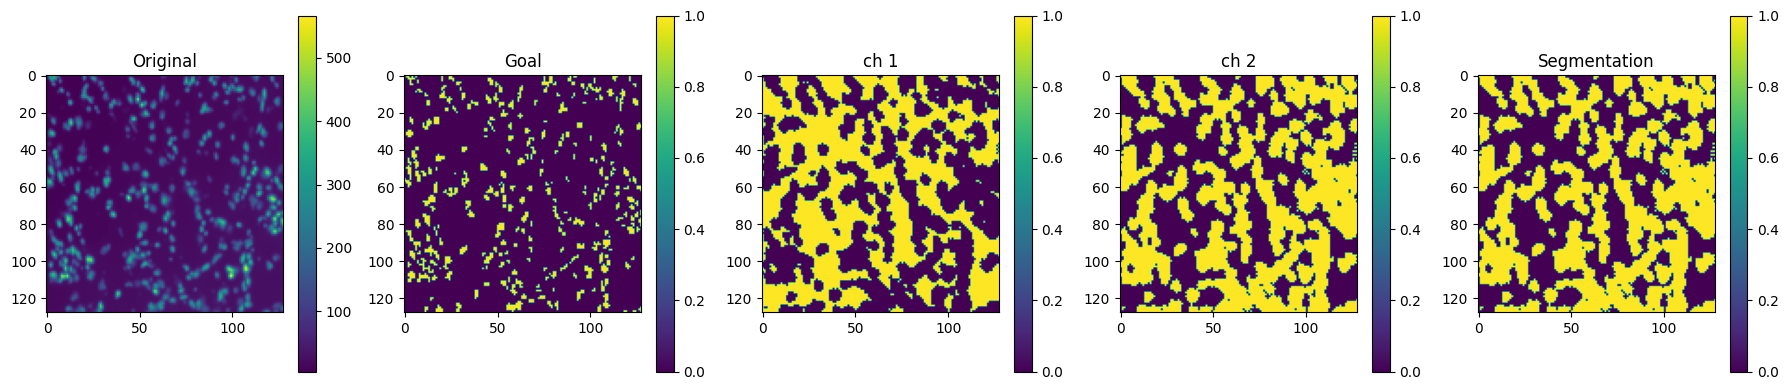

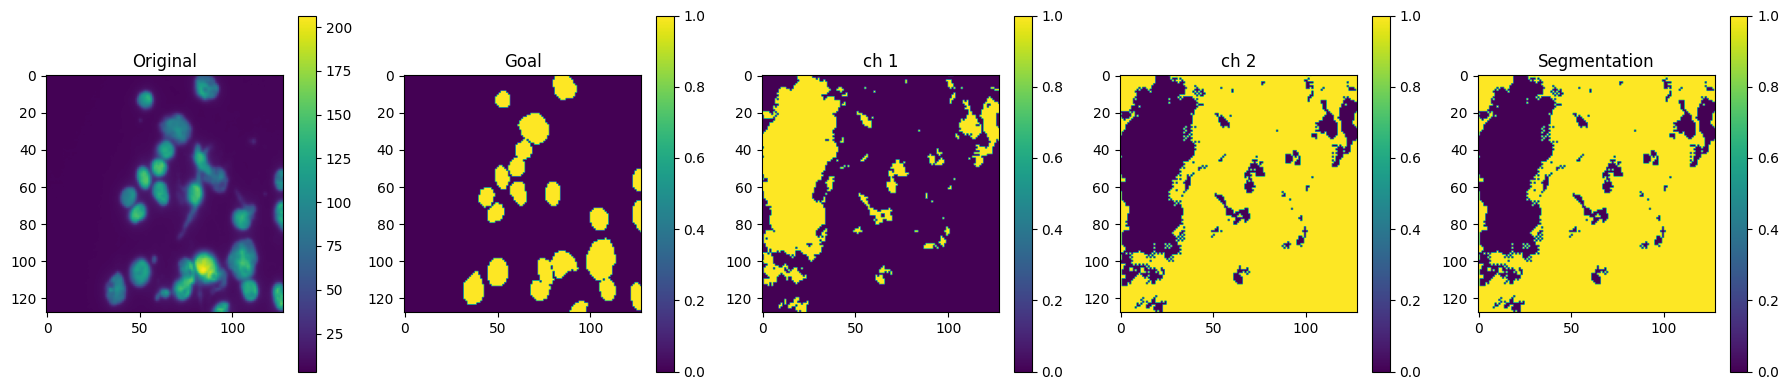

In [ ]:
for i in (3,14):
    figs, axs = plt.subplots(1,5,figsize = (18, 4),tight_layout = True)
    im1 = axs[0].imshow(images[i].squeeze())
    axs[0].set_title('Original')
    figs.colorbar(im1, ax=axs[0],location='right')

    im1 = axs[1].imshow(labels[i])
    axs[1].set_title('Goal')
    figs.colorbar(im1, ax=axs[1],location='right')

    im2 = axs[2].imshow(Classified_Nuclei_1[i])
    axs[2].set_title('ch 1')
    figs.colorbar(im2, ax=axs[2],location='right')

    im3 = axs[3].imshow(Classified_Nuclei_2[i])
    axs[3].set_title('ch 2')
    figs.colorbar(im2, ax=axs[3],location='right')

    im4 = axs[4].imshow(Segmentation[i])
    axs[4].set_title('Segmentation')
    figs.colorbar(im3, ax=axs[4],location='right')


In [ ]:
def Recall_Precision(Classified_Nuclei, labels) :

  true_positives = np.where( labels == 1 , Classified_Nuclei, 0)
  total_true_positives = true_positives.sum()
  total_true = labels.sum()
  total_positives = Classified_Nuclei.sum()

  recall = (total_true_positives/total_true)
  precision = (total_true_positives/total_positives)

  return recall, precision

[recall, precision] = Recall_Precision(Classified_Nuclei_1, labels)
print("Recall : ", recall)
print("Precision : ", precision)

[recall, precision] = Recall_Precision(Segmentation, labels)
print("Recall : ", recall)
print("Precision : ", precision)



Recall :  6.0246406e-05
Precision :  0.00019462258
Recall :  0.99993676
Precision :  0.2778539


In [ ]:
def Comparison_Recall_Precision(model_output, labels, thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.95], plot = False, im = 14) : #[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], [-10,-7,-5,-4,-3,-2,-1,0,1]

  N = len(thresholds)
  recall = np.zeros((N))
  precision = np.zeros((N))

  labels = labels.squeeze().detach().numpy()
  Size = labels.shape
  Segmentation = np.zeros((N,Size[0],Size[1],Size[2]))
  Nuclei_channel1, Nuclei_channel2 = np.zeros((N,Size[0],Size[1],Size[2])), np.zeros((N,Size[0],Size[1],Size[2]))

  for i in range(N) :
    X, Segmentation[i] = Nuclei_classification(model_output, thresholds[i])
    Nuclei_channel1[i], Nuclei_channel2[i] = X[:,0,:,:], X[:,1,:,:]
    [recall[i], precision[i]] = Recall_Precision(Segmentation[i], labels)

  somme = (precision+recall)/2
  X, segmentation = Nuclei_classification(model_output, thresholds[somme.argmax()])

  if plot :
    plt.figure()
    plt.plot(thresholds, recall,'b', label = 'recall')
    plt.plot(thresholds, precision,'r', label = 'precision')
    plt.plot(thresholds, somme,'k', label = 'Sum')
    plt.xlabel("Thresholds")
    plt.grid("minor")
    plt.legend()


    figs, axs = plt.subplots(1,3,figsize = (12, 4),tight_layout = True)
    im1 = axs[0].imshow(labels[im].squeeze())
    axs[0].set_title(' Goal')

    im2  = axs[1].imshow(model_output[im,0,:,:].squeeze().detach().numpy())
    axs[1].set_title(' U-Net ch1')

    im3  = axs[2].imshow(model_output[im,1,:,:].squeeze().detach().numpy())
    axs[2].set_title(' U-Net ch2')

    figs.colorbar(im2, ax=axs[1],location='right')
    figs.colorbar(im3, ax=axs[2],location='right')

    figs, axs = plt.subplots(2,N,figsize = (N*2, N/2),tight_layout = True)
    for i in range(N) :

        im4  = axs[0,i].imshow(Nuclei_channel1[i,im].squeeze())
        axs[0,i].set_title('U-Net final')

        im5  = axs[1,i].imshow(Nuclei_channel2[i,im].squeeze())
        axs[1,i].set_title('U-Net final')

    plt.show()

  return recall[somme.argmax()], precision[somme.argmax()], segmentation



<Figure size 640x480 with 0 Axes>

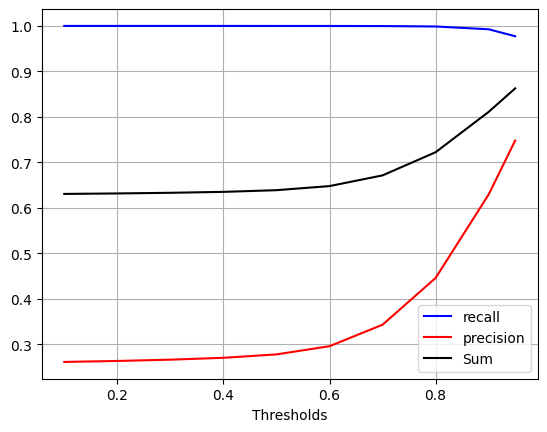

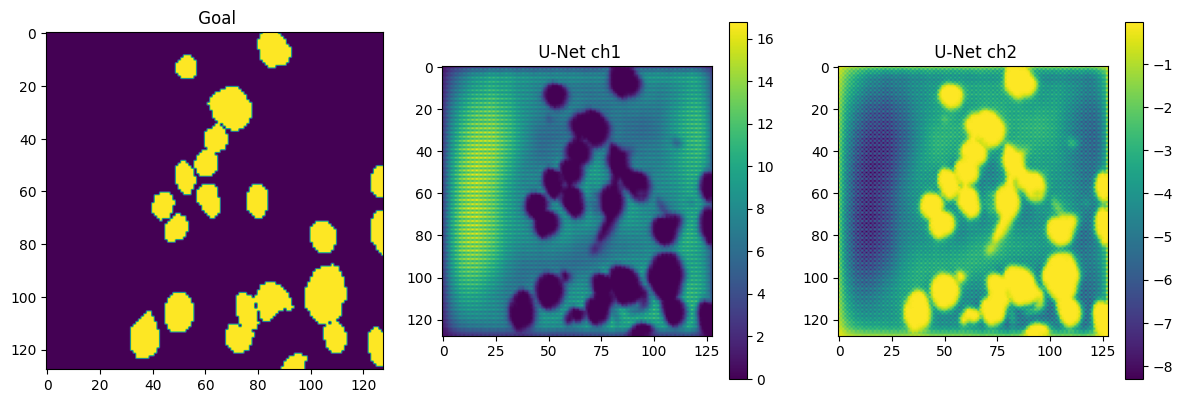

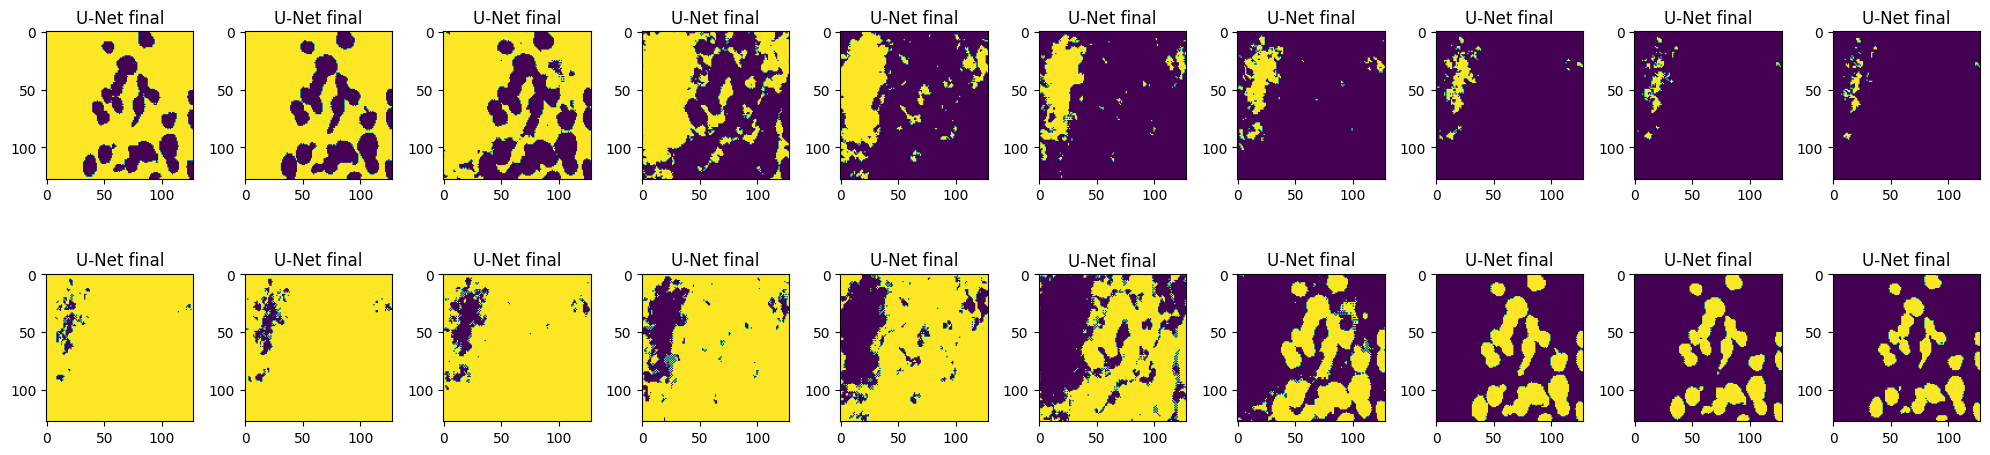

In [ ]:

segmentation_output = model(images)
_, __, segm = Comparison_Recall_Precision(segmentation_output, segmentation_goal, plot = True)

Once the functions are created we proceed to do comparisons between models :

Epoch: 1	 train Loss: 8.45799..  valid Loss: 7.38433.. 
Epoch: 2	 train Loss: 6.35422..  valid Loss: 6.64248.. 
Epoch: 3	 train Loss: 5.86587..  valid Loss: 6.35092.. 
Epoch: 4	 train Loss: 5.29177..  valid Loss: 5.41767.. 
Epoch: 5	 train Loss: 5.06912..  valid Loss: 4.56636.. 
Epoch: 6	 train Loss: 3.81179..  valid Loss: 4.57823.. 
Epoch: 7	 train Loss: 3.47609..  valid Loss: 3.51236.. 
Epoch: 8	 train Loss: 3.00622..  valid Loss: 4.04939.. 
Epoch: 9	 train Loss: 2.71481..  valid Loss: 2.66844.. 
Epoch: 10	 train Loss: 2.70246..  valid Loss: 3.88540.. 
Epoch: 11	 train Loss: 2.31357..  valid Loss: 2.50411.. 
Epoch: 12	 train Loss: 1.92342..  valid Loss: 2.36154.. 
Epoch: 13	 train Loss: 1.68597..  valid Loss: 2.31765.. 
Epoch: 14	 train Loss: 1.69946..  valid Loss: 1.94089.. 
Epoch: 15	 train Loss: 1.61498..  valid Loss: 1.91500.. 
Epoch: 16	 train Loss: 1.50791..  valid Loss: 1.93272.. 
Epoch: 17	 train Loss: 1.38438..  valid Loss: 1.91924.. 
Epoch: 18	 train Loss: 1.28669..  valid 

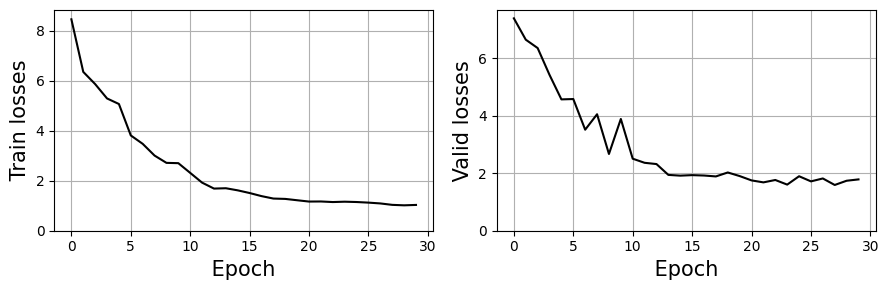

In [ ]:
epochs = 30
F = 8
model1 = U_Net(F)
train(model1, epochs, verbose = True, plot = True)

<Figure size 640x480 with 0 Axes>

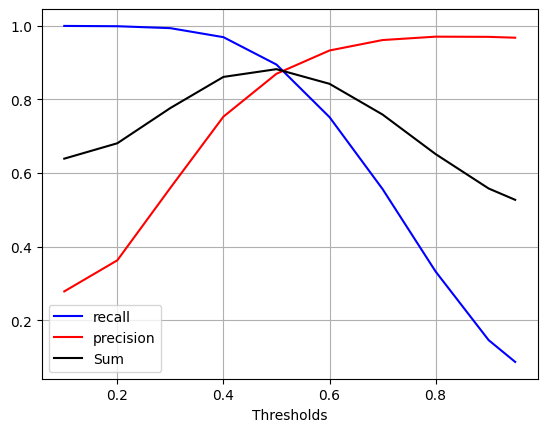

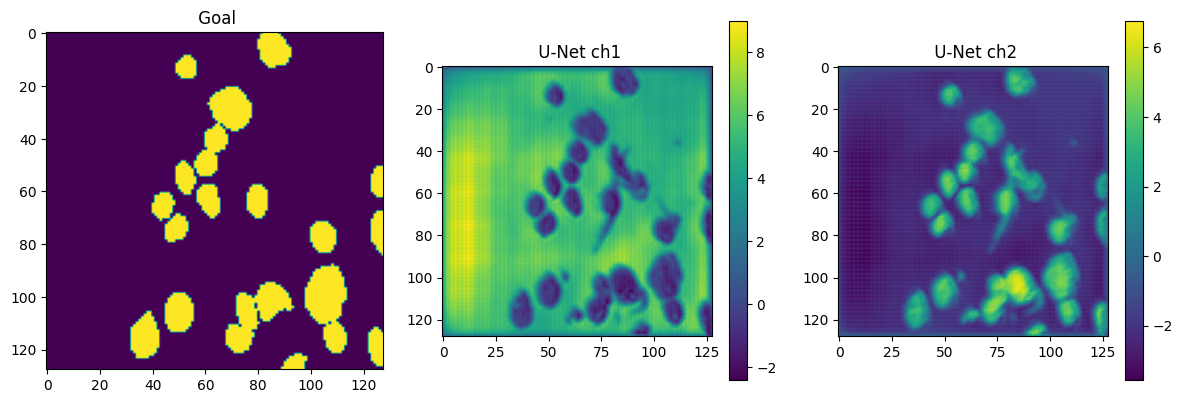

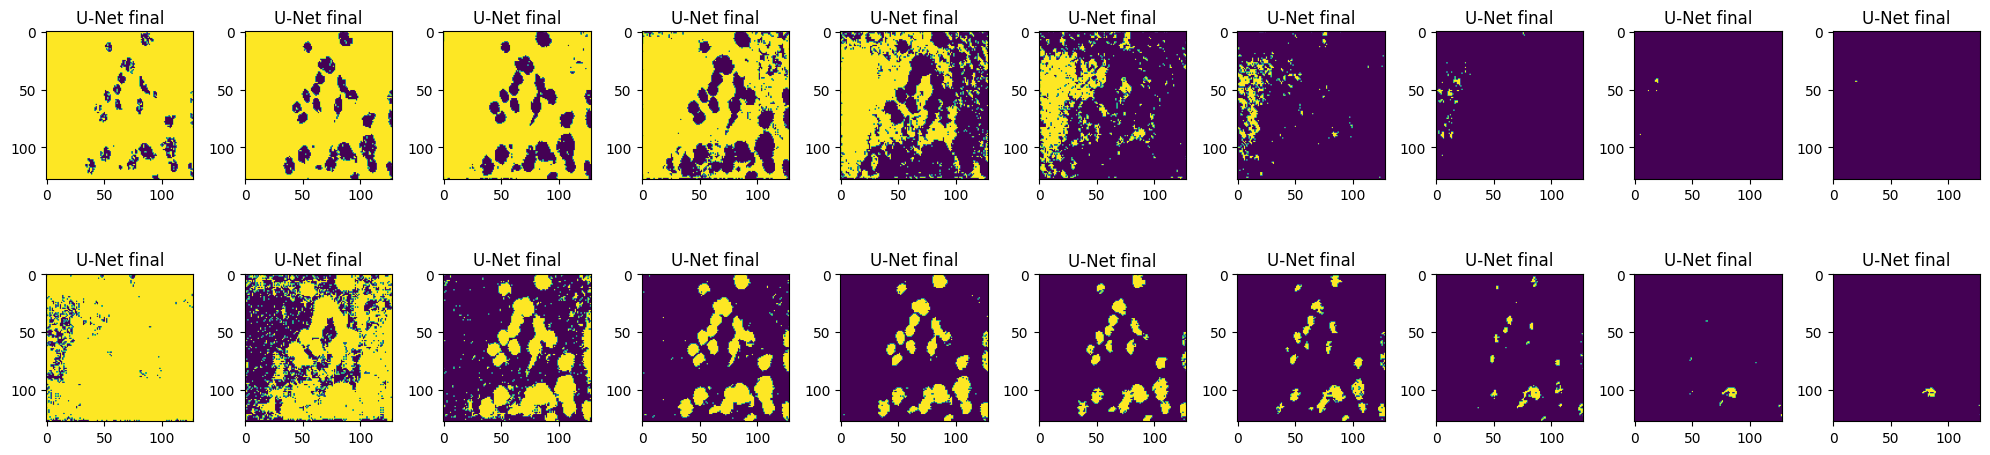

In [ ]:
segmentation_output = model1(images)
_, __, segm1 = Comparison_Recall_Precision(segmentation_output, segmentation_goal, plot = True)

Epoch: 1	 train Loss: 5.80396..  valid Loss: 5.56467.. 
Epoch: 2	 train Loss: 5.56269..  valid Loss: 4.93389.. 
Epoch: 3	 train Loss: 5.13780..  valid Loss: 4.77728.. 
Epoch: 4	 train Loss: 4.29265..  valid Loss: 3.89983.. 
Epoch: 5	 train Loss: 3.70418..  valid Loss: 2.94413.. 
Epoch: 6	 train Loss: 3.64380..  valid Loss: 3.15987.. 
Epoch: 7	 train Loss: 3.99681..  valid Loss: 4.13227.. 
Epoch: 8	 train Loss: 3.05820..  valid Loss: 2.43635.. 
Epoch: 9	 train Loss: 2.18160..  valid Loss: 2.09342.. 
Epoch: 10	 train Loss: 1.60897..  valid Loss: 1.74728.. 
Epoch: 11	 train Loss: 1.66212..  valid Loss: 1.56549.. 
Epoch: 12	 train Loss: 1.50300..  valid Loss: 2.00715.. 
Epoch: 13	 train Loss: 1.19583..  valid Loss: 1.47882.. 
Epoch: 14	 train Loss: 1.12609..  valid Loss: 1.51944.. 
Epoch: 15	 train Loss: 1.14133..  valid Loss: 1.37698.. 
Epoch: 16	 train Loss: 1.08206..  valid Loss: 1.60954.. 
Epoch: 17	 train Loss: 1.05765..  valid Loss: 1.30190.. 
Epoch: 18	 train Loss: 1.05638..  valid 

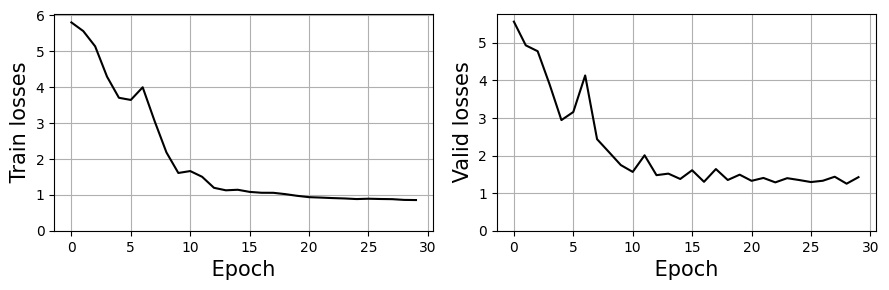

In [ ]:

F = 16
model2 = U_Net(F)
train(model2, epochs,verbose = True, plot = True)

<Figure size 640x480 with 0 Axes>

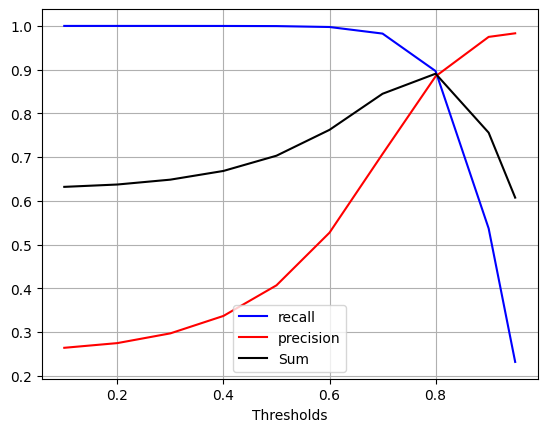

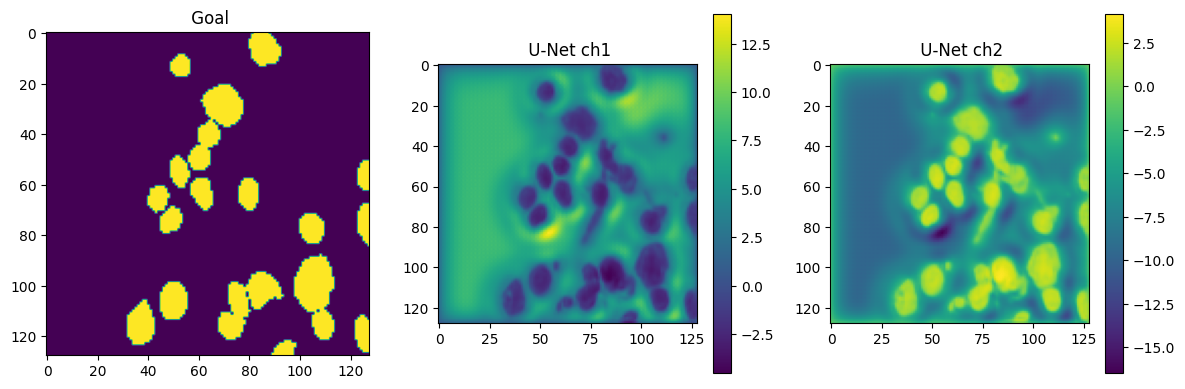

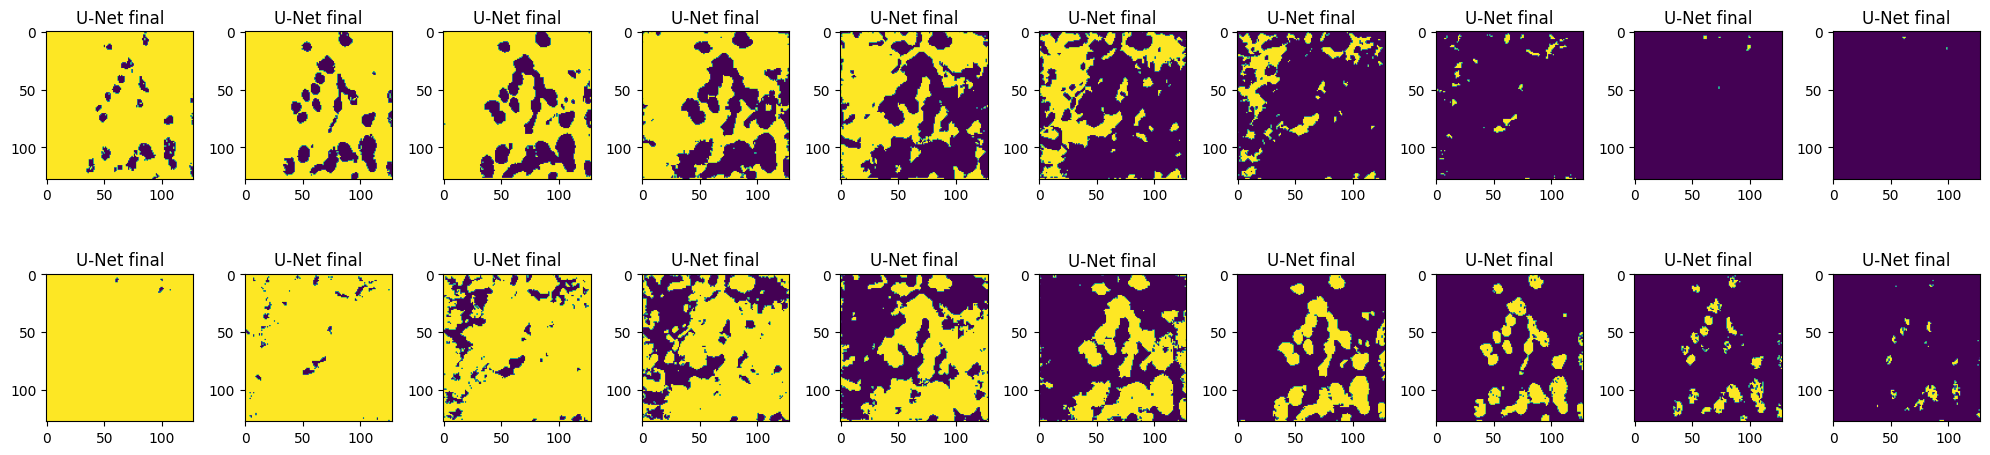

In [ ]:
segmentation_output = model2(images)
_, __, segm2 = Comparison_Recall_Precision(segmentation_output, segmentation_goal, plot = True)

Epoch: 1	 train Loss: 6.51800..  valid Loss: 6.02990.. 
Epoch: 2	 train Loss: 5.81792..  valid Loss: 4.91581.. 
Epoch: 3	 train Loss: 6.24410..  valid Loss: 5.18410.. 
Epoch: 4	 train Loss: 5.74058..  valid Loss: 5.64991.. 
Epoch: 5	 train Loss: 5.43693..  valid Loss: 5.13531.. 
Epoch: 6	 train Loss: 4.93072..  valid Loss: 4.44637.. 
Epoch: 7	 train Loss: 3.98204..  valid Loss: 3.04355.. 
Epoch: 8	 train Loss: 4.61203..  valid Loss: 4.39147.. 
Epoch: 9	 train Loss: 4.34952..  valid Loss: 3.95411.. 
Epoch: 10	 train Loss: 3.94300..  valid Loss: 3.31463.. 
Epoch: 11	 train Loss: 3.16188..  valid Loss: 10.52653.. 
Epoch: 12	 train Loss: 4.77850..  valid Loss: 4.59536.. 
Epoch: 13	 train Loss: 4.14482..  valid Loss: 3.41387.. 
Epoch: 14	 train Loss: 3.24634..  valid Loss: 3.23025.. 
Epoch: 15	 train Loss: 2.43810..  valid Loss: 5.70442.. 
Epoch: 16	 train Loss: 1.91345..  valid Loss: 2.99693.. 
Epoch: 17	 train Loss: 1.57563..  valid Loss: 3.67112.. 
Epoch: 18	 train Loss: 1.61366..  valid

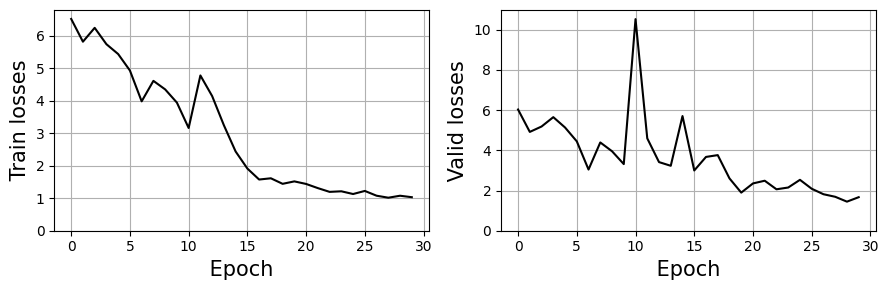

In [ ]:

F = 32
model3 = U_Net(F)
train(model3, epochs,verbose = True, plot = True)

<Figure size 640x480 with 0 Axes>

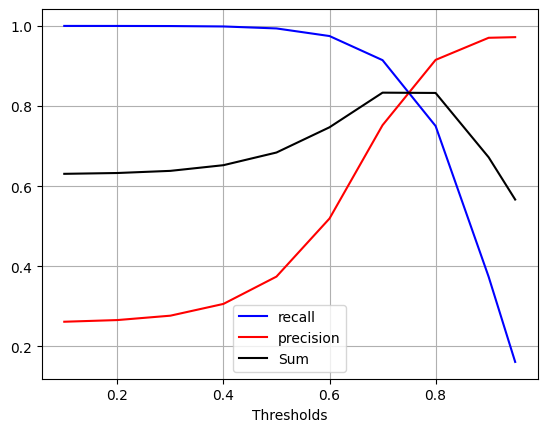

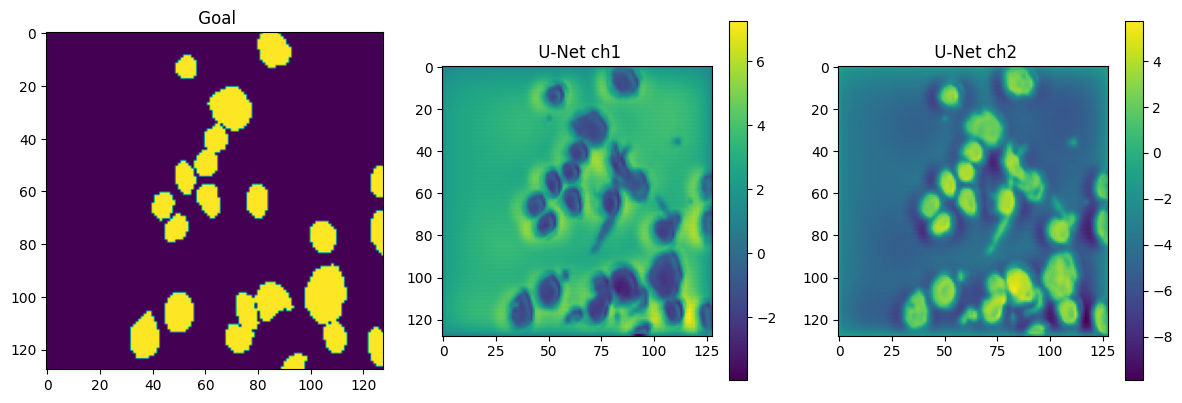

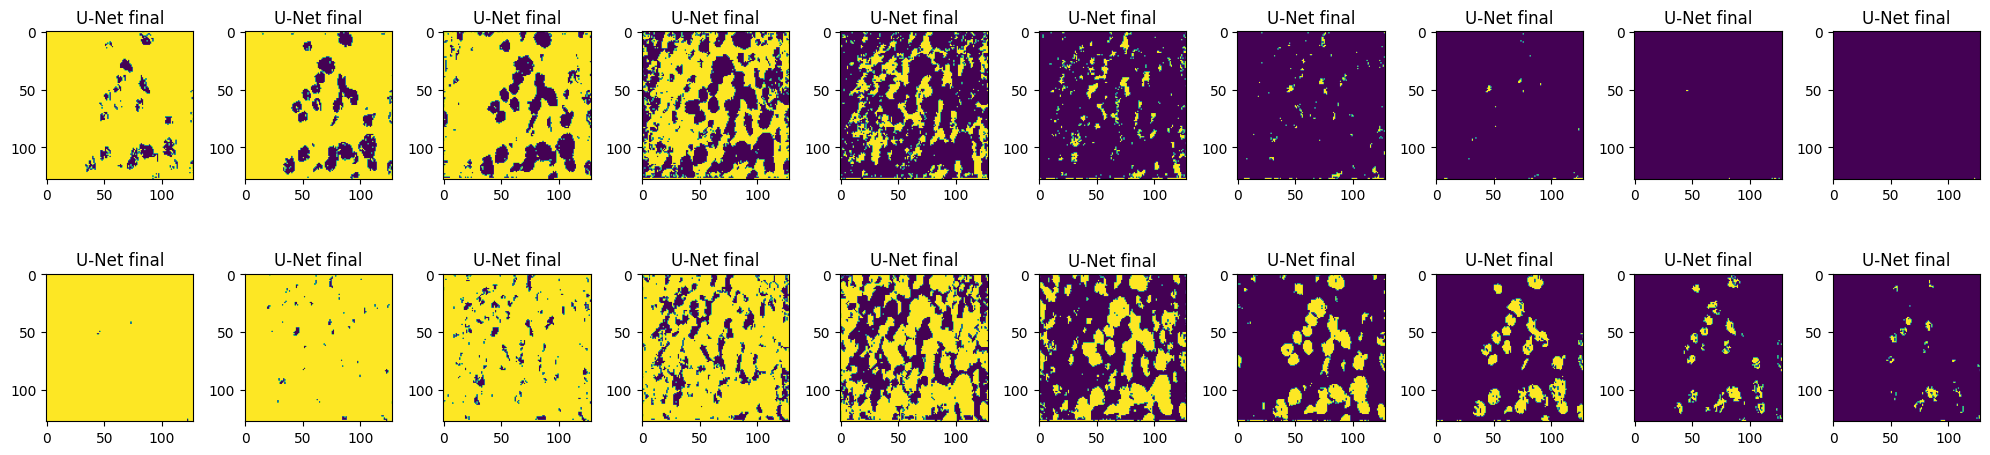

In [ ]:
segmentation_output = model3(images)
_, __, segm3 = Comparison_Recall_Precision(segmentation_output, segmentation_goal, plot = True)

Epoch: 1	 train Loss: 16.91851..  valid Loss: 7.21323.. 
Epoch: 2	 train Loss: 6.59859..  valid Loss: 6.15080.. 
Epoch: 3	 train Loss: 6.17094..  valid Loss: 6.11563.. 
Epoch: 4	 train Loss: 5.46714..  valid Loss: 5.18591.. 
Epoch: 5	 train Loss: 4.90130..  valid Loss: 4.30609.. 
Epoch: 6	 train Loss: 5.89397..  valid Loss: 5.11029.. 
Epoch: 7	 train Loss: 4.75579..  valid Loss: 4.26074.. 
Epoch: 8	 train Loss: 3.83375..  valid Loss: 2.88060.. 
Epoch: 9	 train Loss: 4.13312..  valid Loss: 6.85391.. 
Epoch: 10	 train Loss: 2.88246..  valid Loss: 3.06444.. 
Epoch: 11	 train Loss: 2.28610..  valid Loss: 2.33722.. 
Epoch: 12	 train Loss: 1.95574..  valid Loss: 2.16852.. 
Epoch: 13	 train Loss: 1.89440..  valid Loss: 1.50382.. 
Epoch: 14	 train Loss: 2.19250..  valid Loss: 1.80424.. 
Epoch: 15	 train Loss: 2.00116..  valid Loss: 2.16770.. 
Epoch: 16	 train Loss: 1.39025..  valid Loss: 2.81159.. 
Epoch: 17	 train Loss: 1.23264..  valid Loss: 2.11099.. 
Epoch: 18	 train Loss: 1.09743..  valid

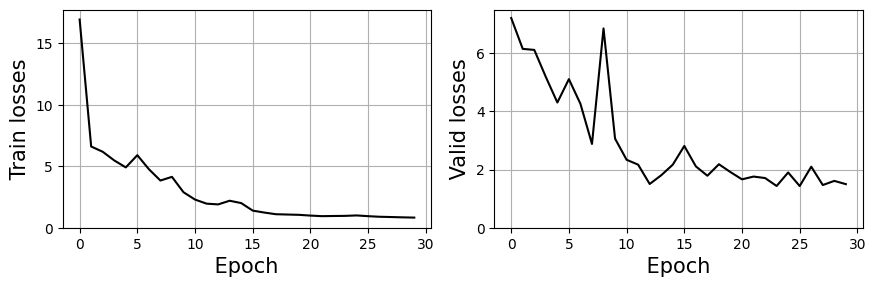

In [ ]:

F = 64
model4 = U_Net(F)
train(model4, epochs,verbose = True, plot = True)

<Figure size 640x480 with 0 Axes>

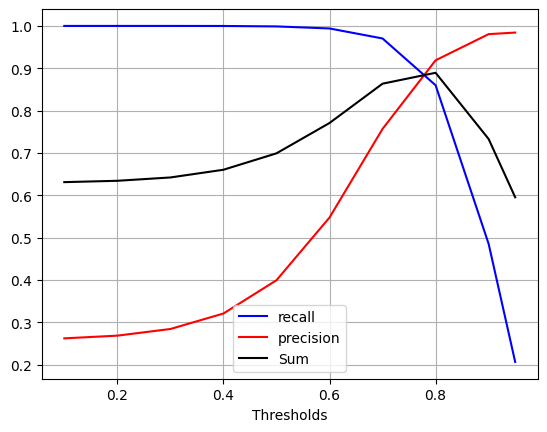

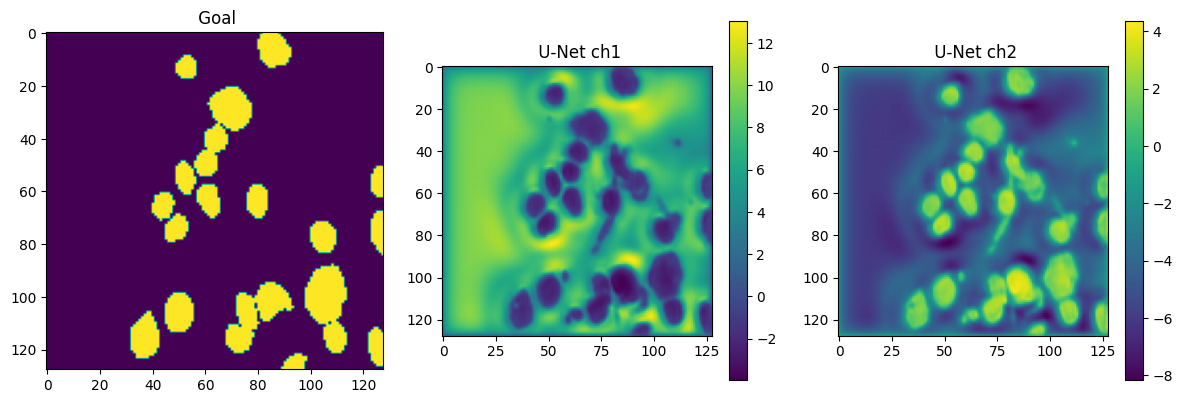

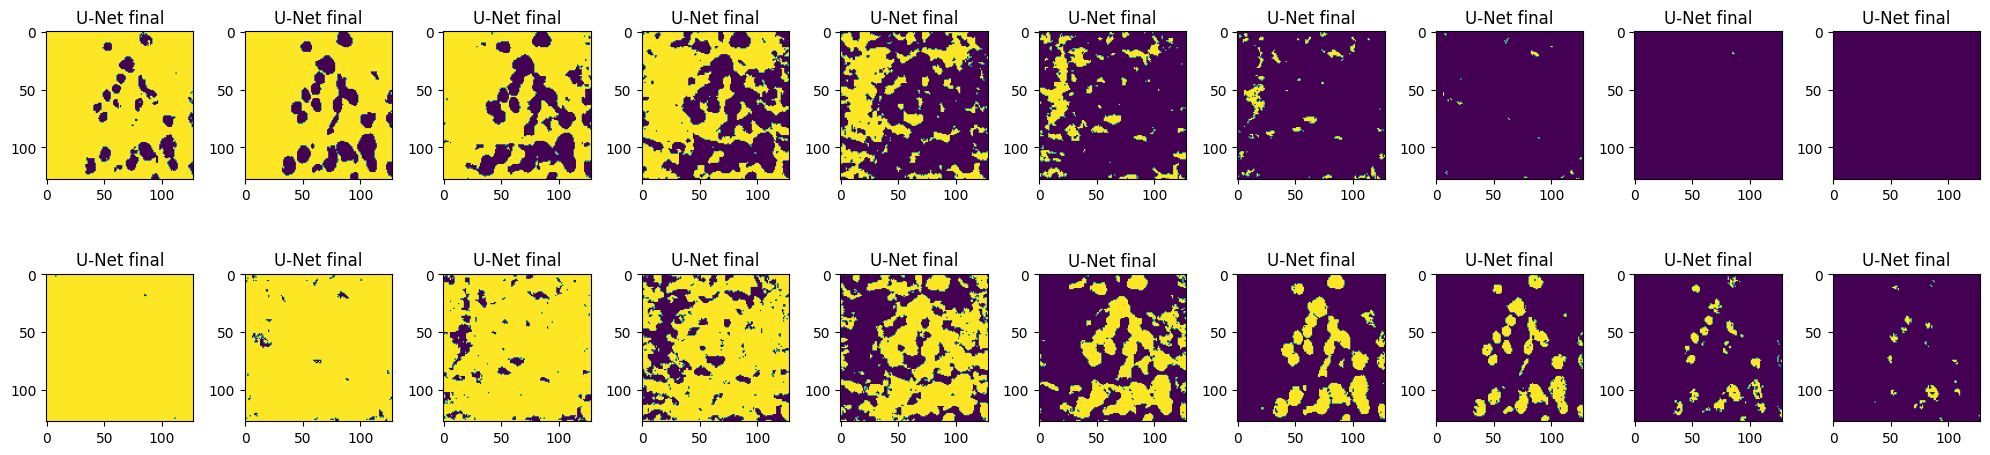

In [ ]:
segmentation_output = model4(images)
_, __, segm4 = Comparison_Recall_Precision(segmentation_output, segmentation_goal, plot = True)

Training data


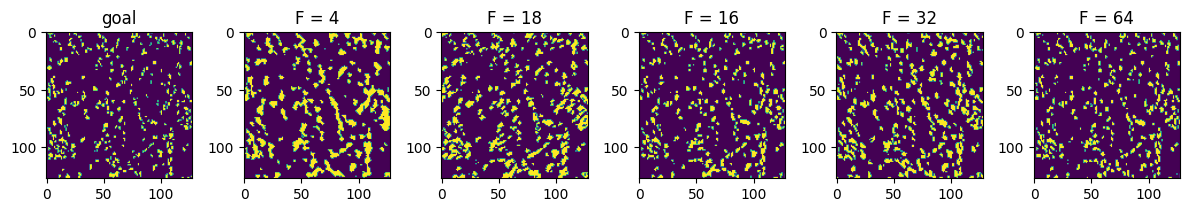

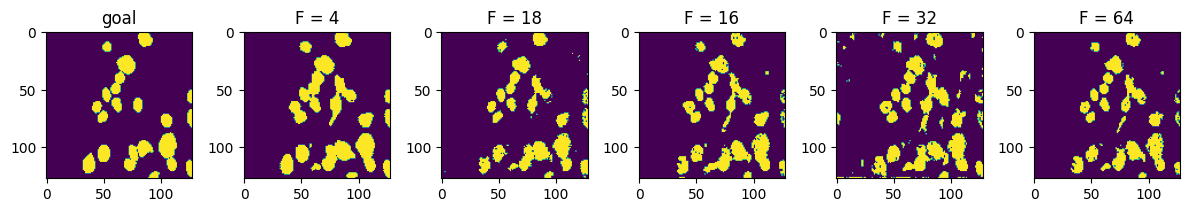

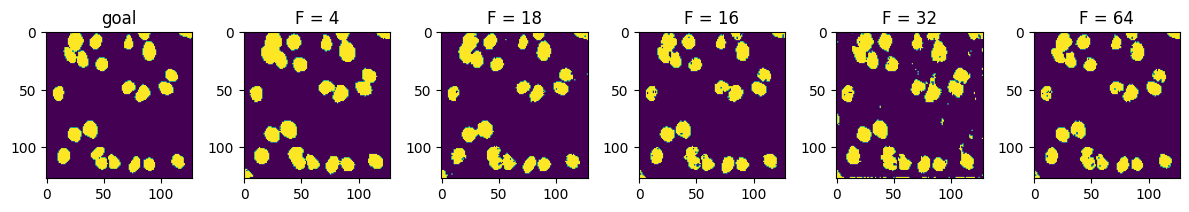

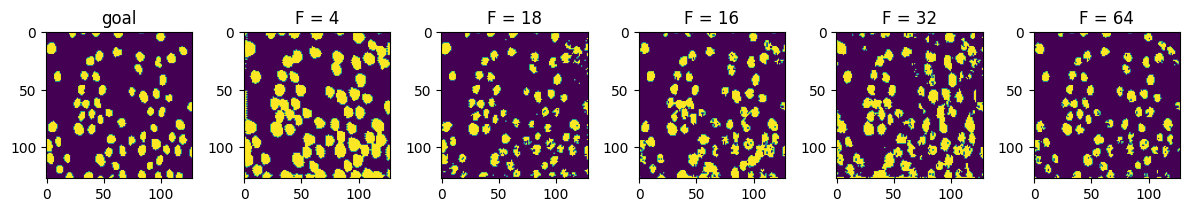

In [ ]:
print("Training data")

goal = segmentation_goal.squeeze().detach().numpy()
for i in (3,14,50,60):
  figs, axs = plt.subplots(1,6,figsize = (6*2, 6/2),tight_layout = True)
  im0  = axs[0].imshow(goal[i])
  axs[0].set_title('goal')

  im0  = axs[1].imshow(segm[i])
  axs[1].set_title('F = 4')

  im1  = axs[2].imshow(segm1[i])
  axs[2].set_title('F = 18')

  im2  = axs[3].imshow(segm2[i])
  axs[3].set_title('F = 16')

  im1  = axs[4].imshow(segm3[i])
  axs[4].set_title('F = 32')

  im2  = axs[5].imshow(segm4[i])
  axs[5].set_title('F = 64')

In [ ]:

images = Xvalid
segmentation_goal_ = Yvalid
segmentation_output = model(images)
_, __, segm_ = Comparison_Recall_Precision(segmentation_output, segmentation_goal_)
print("precision : ", __, "recall : ", _)

segmentation_output = model1(images)
_, __, segm_1 = Comparison_Recall_Precision(segmentation_output, segmentation_goal_)
print("precision : ", __, "recall : ", _)


segmentation_output = model2(images)
_, __, segm_2 = Comparison_Recall_Precision(segmentation_output, segmentation_goal_)
print("precision : ", __, "recall : ", _)


segmentation_output = model3(images)
_, __, segm_3 = Comparison_Recall_Precision(segmentation_output, segmentation_goal_)
print("precision : ", __, "recall : ", _)


segmentation_output = model4(images)
_, __, segm_4 = Comparison_Recall_Precision(segmentation_output, segmentation_goal_)
print("precision : ", __, "recall : ", _)




precision :  0.7973552365353117 recall :  0.9093731113675073
precision :  0.7779891562826976 recall :  0.8987418273721224
precision :  0.8404750400528953 recall :  0.907917147409483
precision :  0.7960465680329857 recall :  0.9016262842700951
precision :  0.7677073063862416 recall :  0.9626394154167354


Validation data


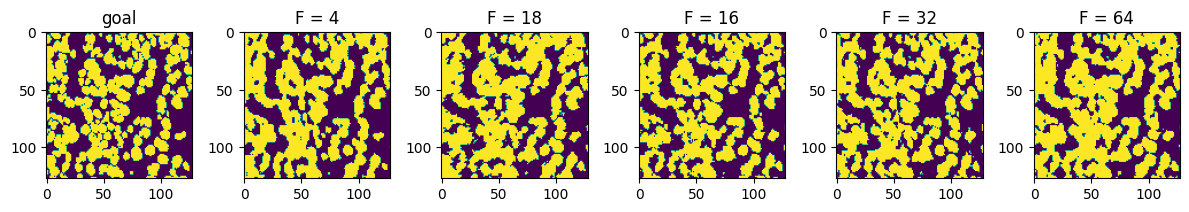

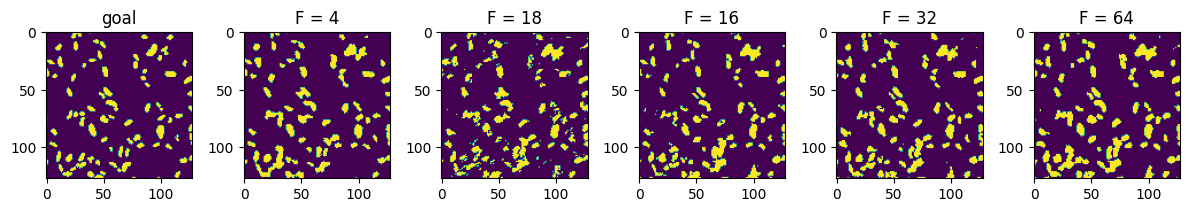

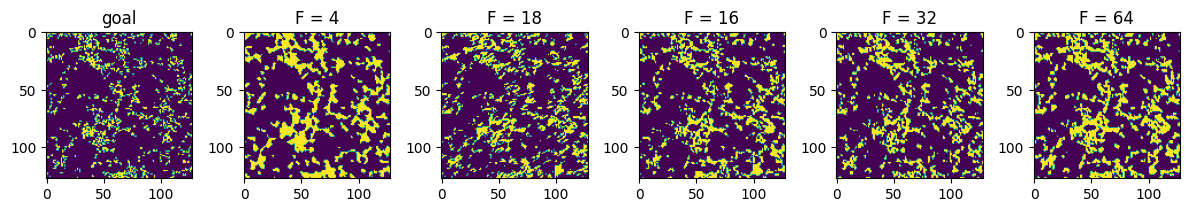

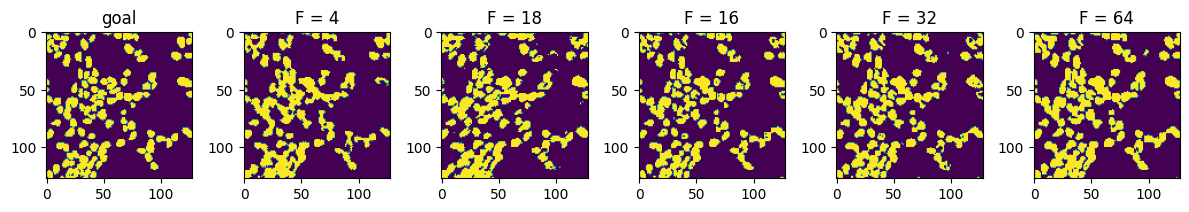

In [ ]:
print("Validation data")
goal_ = segmentation_goal_.squeeze().detach().numpy()
for i in (1,3,5,8):
  figs, axs = plt.subplots(1,6,figsize = (6*2, 6/2),tight_layout = True)
  im0  = axs[0].imshow(goal_[i])
  axs[0].set_title('goal')

  im0  = axs[1].imshow(segm_[i])
  axs[1].set_title('F = 4')

  im1  = axs[2].imshow(segm_1[i])
  axs[2].set_title('F = 18')

  im2  = axs[3].imshow(segm_2[i])
  axs[3].set_title('F = 16')

  im1  = axs[4].imshow(segm_3[i])
  axs[4].set_title('F = 32')

  im2  = axs[5].imshow(segm_4[i])
  axs[5].set_title('F = 64')

# Data Augmentation
When the dataset is scarce, we can try data-augmentation. The idea is to apply transformation introduce diversity in the dataset with basic transformation. [Look at this page for more information](https://pytorch.org/vision/main/transforms.html).

**TODO:**
- Select a couple of transformation
- Evaluate the impact of data-augmentation on our task.


